In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import geopandas as gpd

# import itables
# itables.init_notebook_mode()
# itables.init_notebook_mode(all_interactive=True)




# Reading the Species 

here's the output of the `SpeciesList.csv`

In [3]:

spps = pd.read_csv('SpeciesList.csv')
display(spps)

,Seq,AOU,English_Common_Name,French_Common_Name,Order,Family,Genus,Species
0,6,1770,Black-bellied Whistling-Duck,Dendrocygne à ventre noir,Anseriformes,Anatidae,Dendrocygna,autumnalis
1,7,1780,Fulvous Whistling-Duck,Dendrocygne fauve,Anseriformes,Anatidae,Dendrocygna,bicolor
2,8,1760,Emperor Goose,Oie empereur,Anseriformes,Anatidae,Anser,canagicus
3,9,1690,Snow Goose,Oie des neiges,Anseriformes,Anatidae,Anser,caerulescens
4,10,1691,(Blue Goose) Snow Goose,Oie des neiges (forme bleue),Anseriformes,Anatidae,Anser,caerulescens (blue form)
...,...,...,...,...,...,...,...,...
758,1332,5980,Indigo Bunting,Passerin indigo,Passeriformes,Cardinalidae,Passerina,cyanea
759,1333,5986,hybrid Lazuli Bunting x Indigo Bunting,hybride Passerin azuré x Passerin indigo,Passeriformes,Cardinalidae,Passerina,amoena x cyanea
760,1336,6000,Varied Bunting,Passerin varié,Passeriformes,Cardinalidae,Passerina,versicolor
761,1337,6010,Painted Bunting,Passerin nonpareil,Passeriformes,Cardinalidae,Passerina,ciris


# Reading Route file

we will add a column to indicate the route id as `ruta`. It will be the merge of `ruta`=`CoutryNum`+`StateNum`+Route`

In [4]:
# print(os.listdir('.'))
routes = pd.read_csv('./Routes.csv', encoding='ISO-8859-1')

routes['ruta'] = routes['CountryNum'].astype(str) + routes['StateNum'].astype(str) + routes['Route'].astype(str)

routes.head()

,CountryNum,StateNum,Route,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID,ruta
0,840,2,1,ST FLORIAN,1,34.868688,-87.604142,14,27,1,1,84021
1,840,2,2,HILLSBORO,0,34.638675,-87.191292,14,24,1,1,84022
2,840,2,3,FLORENCE,0,34.800000,-87.733333,14,24,1,1,84023
3,840,2,4,TRADE,1,34.029788,-87.059235,13,28,1,1,84024
4,840,2,5,SUMMITT,0,34.201669,-86.493409,13,28,1,1,84025


## Reading abundance data from Stop files

In [5]:
def read_routes_BBS(directory_path):
    """
    Reads all CSV files starting with 'F' in a specified directory
    and combines them into a single large Pandas DataFrame.

    Args:
        directory_path (str): The path to the directory containing the CSV files.

    Returns:
        pandas.DataFrame: A single DataFrame containing data from all
                          matching CSV files, or an empty DataFrame if no
                          matching files are found or an error occurs.
    """
    # Construct the search pattern for CSV files starting with 'F'
    search_pattern = os.path.join(directory_path, 'F*.csv')
    
    # Find all files matching the pattern
    csv_files = glob.glob(search_pattern)

    # Check if any files were found
    if not csv_files:
        print(f"No CSV files starting with 'F' found in: {directory_path}")
        return pd.DataFrame() # Return an empty DataFrame

    # List to hold individual DataFrames
    dataframes = []

    print(f"Found {len(csv_files)} CSV files starting with 'F':")
    for file_path in csv_files:
        print(f"  - {os.path.basename(file_path)}")
        try:
            # Read each CSV file into a DataFrame
            df = pd.read_csv(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {os.path.basename(file_path)}: {e}")
            continue # Continue to the next file even if one fails

    # Concatenate all DataFrames into one large DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        return combined_df
    else:
        print("No DataFrames were successfully loaded.")
        return pd.DataFrame() # Return an empty DataFrame if no data was loaded


In [6]:
data = read_routes_BBS('50-StopData/')

Found 9 CSV files starting with 'F':
  - Fifty2.csv
  - Fifty10.csv
  - Fifty1.csv
  - Fifty3.csv
  - Fifty6.csv
  - Fifty5.csv
  - Fifty4.csv
  - Fifty9.csv
  - Fifty8.csv


### Number of individuals (abundance) per route

We sum the abundance of each species across the 50 stops per route. The result is a dataframe with the columns `ruta`, `species` (AOU), and `Number of individuals`.

In [7]:

Totals = pd.concat([data[data.columns[:7].tolist()],data.iloc[:,-50:].sum(axis=1)], axis=1)
Totals.rename(columns={0: 'Number of individuals'}, inplace=True)

Totals['ruta'] = Totals['CountryNum'].astype(str)  + Totals['StateNum'].astype(str) + Totals['Route'].astype(str)



Adding the coordinates of the route as `lat` and `lon` columns. The coordinates are the start location of each route.

In [8]:
Totals  = Totals.merge(routes.iloc[:,3:], on='ruta', how='left')


In [9]:
display(Totals)

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Number of individuals,ruta,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID
0,6227579,124,11,1,101,1997,1320,9,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
1,6227579,124,11,1,101,1997,1720,32,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
2,6227579,124,11,1,101,1997,2300,1,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
3,6227579,124,11,1,101,1997,2730,1,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
4,6227579,124,11,1,101,1997,2940,8,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4085888,6381048,840,80,901,101,2023,7290,3,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
4085889,6381048,840,80,901,101,2023,7310,48,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
4085890,6381048,840,80,901,101,2023,7360,42,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
4085891,6381048,840,80,901,101,2023,7510,16,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2


In [10]:
Totals['ruta'].drop_duplicates().describe()

count         4522
unique        4522
top       84080901
freq             1
Name: ruta, dtype: object

# Summary for total dataset


1. **Species**
We need to build a table listing the species, the earliest year in which the species was found, the last year,  and the number of routes in which the species has been recorded

That is, columns could be:
 - spp
 - min year
 - max year
 - n_routes
  
2. **Routes**
This is a geographic view. We will need to build a table listing the main properties of routes. One option is to build a table that will list each route, route coords, the year of first sample, the year of last sample and the number of species sampled. We could also add a vector with the richness per year.

That is, columns
 - Route ID
 - (lon, lat)
 - first year
 - last year
 - total richness 

> There's a total of 4522 unique routes starting in 1967 until 2023

In [11]:
spp_summary = Totals[['AOU','ruta','Year']].groupby(['AOU']).agg(['count','min','max']).reset_index()
# spp_summary.columns
spp_summary.drop(columns=[('ruta','min'),('ruta','max'),('Year','count')],inplace=True)
spp_summary.columns =['AOU','n_rutas','first_year','last_year']
spp_summary['timeseries length'] = spp_summary['last_year'] - spp_summary['first_year']

spp_summary = spp_summary.merge(spps.iloc[:, 1:],on='AOU',how='left')

display(spp_summary.sort_values(by='n_rutas',ascending=False))

,AOU,n_rutas,first_year,last_year,timeseries length,English_Common_Name,French_Common_Name,Order,Family,Genus,Species
243,3160,66263,1967,2023,56,Mourning Dove,Tourterelle triste,Columbiformes,Columbidae,Zenaida,macroura
718,7610,63383,1968,2023,55,American Robin,Merle d'Amérique,Passeriformes,Turdidae,Turdus,migratorius
450,4980,60790,1967,2023,56,Red-winged Blackbird,Carouge à épaulettes,Passeriformes,Icteridae,Agelaius,phoeniceus
445,4950,59694,1967,2023,56,Brown-headed Cowbird,Vacher à tête brune,Passeriformes,Icteridae,Molothrus,ater
435,4880,57466,1968,2023,55,American Crow,Corneille d'Amérique,Passeriformes,Corvidae,Corvus,brachyrhynchos
...,...,...,...,...,...,...,...,...,...,...,...
177,2422,1,2023,2023,0,Red-necked Stint,Bécasseau à col roux,Charadriiformes,Scolopacidae,Calidris,ruficollis
17,210,1,1997,1997,0,Ancient Murrelet,Guillemot à cou blanc,Charadriiformes,Alcidae,Synthliboramphus,antiquus
11,90,1,2011,2011,0,Arctic Loon,Plongeon arctique,Gaviiformes,Gaviidae,Gavia,arctica
14,120,1,2007,2007,0,Tufted Puffin,Macareux huppé,Charadriiformes,Alcidae,Fratercula,cirrhata


### Timeseries length distribution

- the frequency of timeseries length across all species.
- the number of routes per species and the length of their timeseries

Text(0.5, 0, 'timeseries length (years)')

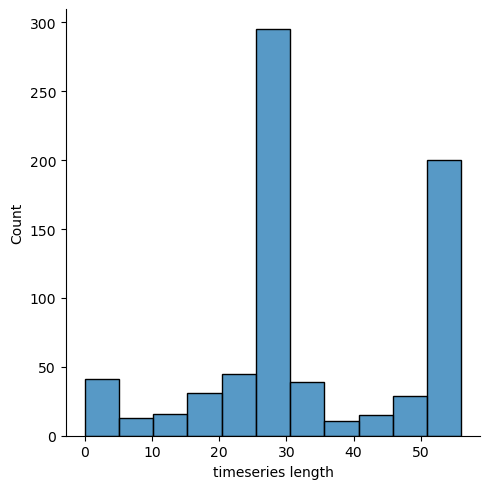

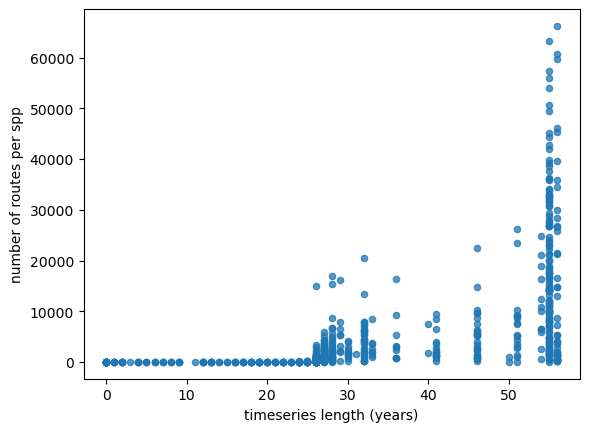

In [12]:
sns.displot(spp_summary['timeseries length'])
spp_summary.plot.scatter('timeseries length','n_rutas',alpha=.75)
plt.ylabel('number of routes per spp')
plt.xlabel('timeseries length (years)')

In [17]:
spp_summary[spp_summary['timeseries length']>=50]

,AOU,n_rutas,first_year,last_year,timeseries length,English_Common_Name,French_Common_Name,Order,Family,Genus,Species
7,60,3842,1967,2023,56,Pied-billed Grebe,Grèbe à bec bigarré,Podicipediformes,Podicipedidae,Podilymbus,podiceps
31,440,924,1972,2023,51,Glaucous-winged Gull,Goéland à ailes grises,Charadriiformes,Laridae,Larus,glaucescens
43,580,1998,1967,2023,56,Laughing Gull,Mouette atricille,Charadriiformes,Laridae,Leucophaeus,atricilla
47,630,246,1967,2023,56,Gull-billed Tern,Sterne hansel,Charadriiformes,Laridae,Gelochelidon,nilotica
53,690,1082,1967,2023,56,Forster's Tern,Sterne de Forster,Charadriiformes,Laridae,Sterna,forsteri
...,...,...,...,...,...,...,...,...,...,...,...
717,7590,18579,1968,2023,55,Hermit Thrush,Grive solitaire,Passeriformes,Turdidae,Catharus,guttatus
718,7610,63383,1968,2023,55,American Robin,Merle d'Amérique,Passeriformes,Turdidae,Turdus,migratorius
720,7630,5208,1972,2023,51,Varied Thrush,Grive à collier,Passeriformes,Turdidae,Ixoreus,naevius
723,7660,32721,1968,2023,55,Eastern Bluebird,Merlebleu de l'Est,Passeriformes,Turdidae,Sialia,sialis


In [14]:
Totals[Totals['AOU']==4050]

,RouteDataID,CountryNum,StateNum,Route,RPID,Year,AOU,Number of individuals,ruta,RouteName,Active,Latitude,Longitude,Stratum,BCR,RouteTypeID,RouteTypeDetailID
11,6227579,124,11,1,101,1997,4050,1,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
71,6233581,124,11,1,101,1998,4050,2,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
126,6232730,124,11,1,101,1999,4050,1,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
188,6170311,124,11,1,101,2000,4050,1,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
350,6317511,124,11,1,101,2010,4050,1,124111,CHEMAINUS,0,48.785290,-123.599130,94,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4085385,6344277,840,80,901,101,2012,4050,2,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
4085663,6367848,840,80,901,101,2018,4050,2,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
4085763,6375027,840,80,901,101,2021,4050,1,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2
4085817,6377287,840,80,901,101,2022,4050,2,84080901,KIAWAH ISLAND,1,32.604127,-80.155559,3,27,1,2


# We may look at a few species
We can look at some species.


Text(0, 0.5, 'Individuals')

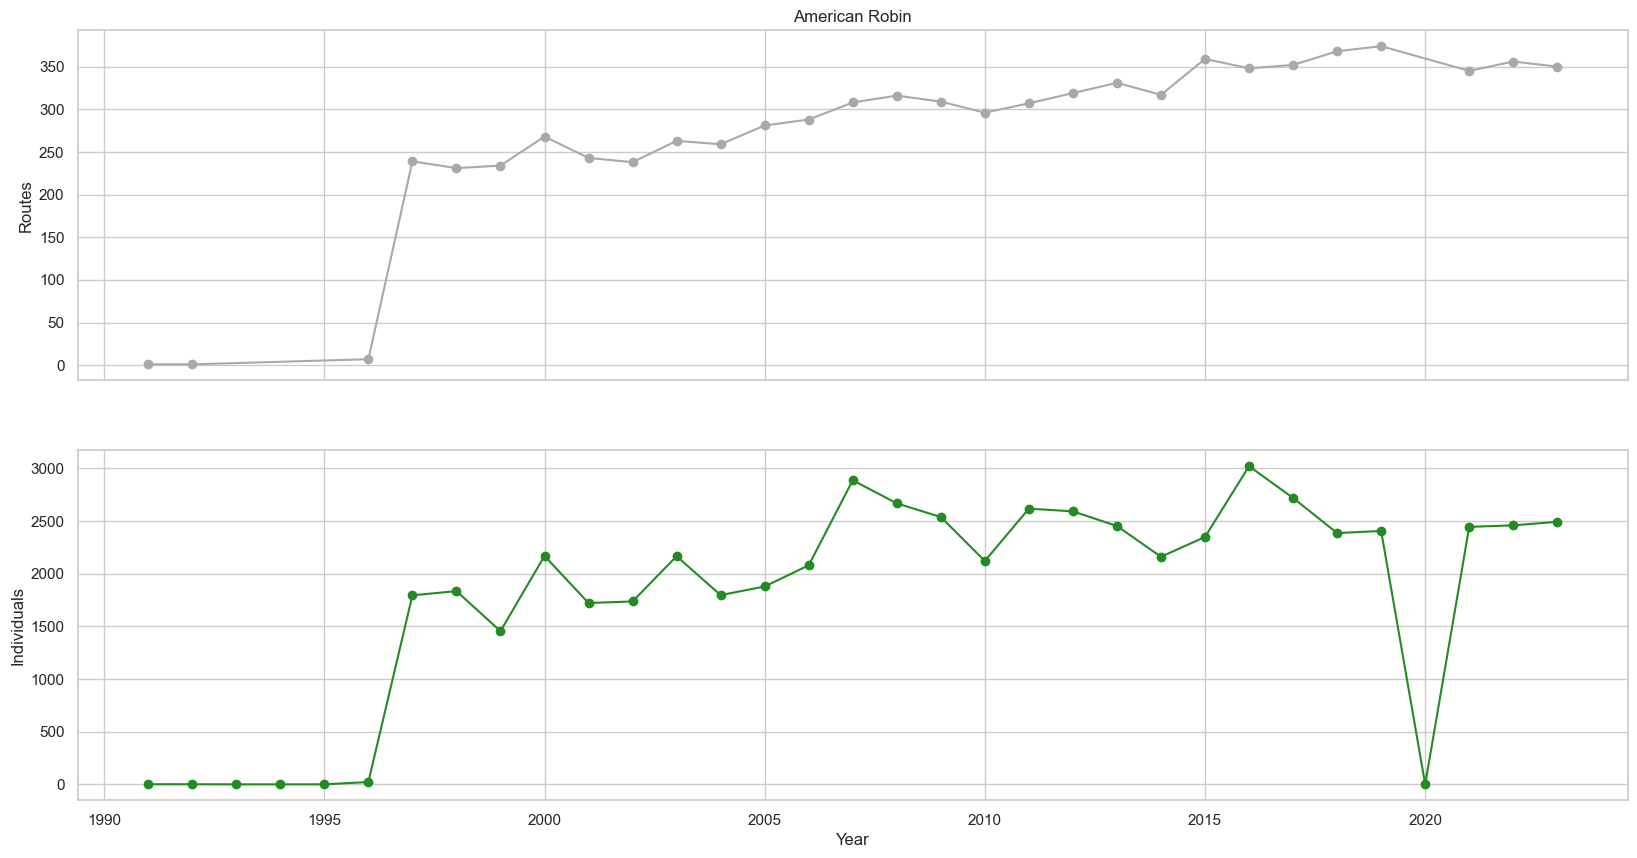

<Figure size 1500x500 with 0 Axes>

<Figure size 2000x400 with 0 Axes>

In [90]:
# Totals[(Totals['RouteDataID']==6346138) & (Totals['AOU']==2060)]['Year']

# spp = 4920 # Piñon Jay  ([Gymnorhinus cyanocephalus](https://www.allaboutbirds.org/guide/Pinyon_Jay/))
spp = 2060 # 
sppname = 'American Robin'
# spp = 2010 # 
# sppname = 'Black-throated Sparrow'
# spp = 7360
# sppname = 'Carolina Chickadee'
# spp = 4930
# sppname = 'European Starling'
# spp = 4770 #
# sppname = 'Blue Jay'
# spp = 5935 #
# sppname = 'Northern Cardinal'
# spp = 7030 #
# sppname = 'Northern Mockingbird'
# spp = 10
# sppname = 'Western Grebe'# (_Aechmophorus,occidentalis_)

# spp = 5330
# sppname = 'Pine Siskin'

# spp = 7630
# sppname = 'Varied Thrush'
# Plot the number of routes per year for the specified species
sns.set(style="whitegrid")



fig, axes = plt.subplots( 2,1, figsize=(20, 10))
plt.figure(figsize=(15, 5))
Totals[Totals['AOU']==spp][['Year','ruta']].groupby('Year').count().plot(kind='line', title=sppname,
                                                                         linestyle='-', marker='o',ax=axes[0],
                                                                         legend='',color='darkgrey')
axes[0].set_xlabel('')
axes[0].set_ylabel('Routes')

axes[0].set_xticklabels([])

# total abundance
d = Totals[Totals['AOU']==spp][['Year','Number of individuals']].groupby('Year').sum().reset_index()#.plot('Year','Number of individuals')
all_years = pd.DataFrame({'Year': range(d['Year'].min(), d['Year'].max() + 1)})

dd = pd.merge(all_years, d, on='Year', how='left').fillna(0)

plt.figure(figsize=(20, 4))
dd.plot('Year','Number of individuals',linestyle='-', marker='o',
        ax=axes[1],legend='',color='Forestgreen')
axes[1].set_ylabel('Individuals')

# Totals[Totals['AOU']==4920]

2060


Text(0.02, 0.95, 'Important Note: Data from 2024')

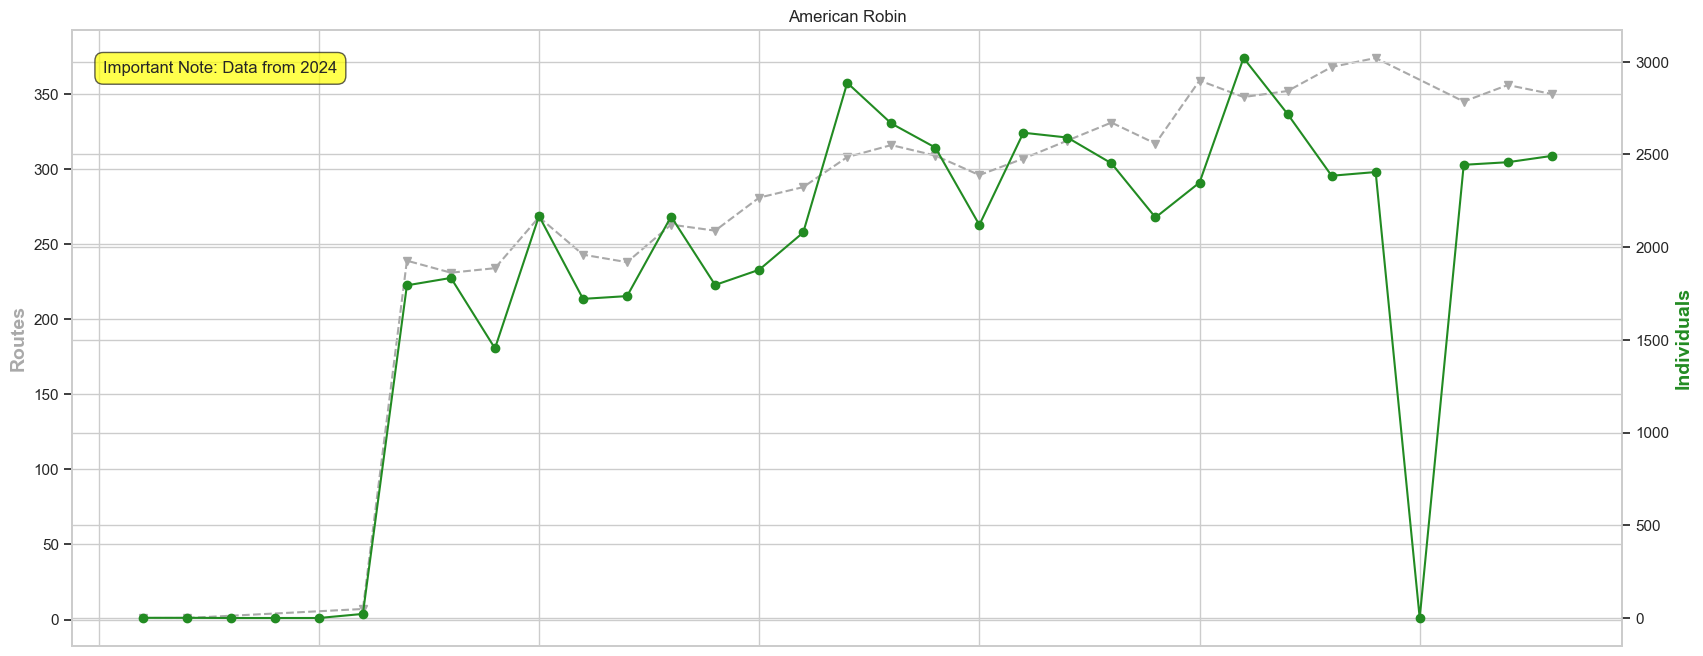

In [117]:
# spp_summary[spp_summary['timeseries length']>=50][['AOU','English_Common_Name']]

fig, ax1 = plt.subplots(figsize=(20, 8))

Totals[Totals['AOU']==spp][['Year','ruta']].groupby('Year').count().plot(kind='line', title=sppname,
                                                                         linestyle='--', marker='v',ax=ax1,
                                                                         legend='',color='darkgrey')
ax1.set_xlabel('')
ax1.set_ylabel('Routes',color='darkgrey', fontsize=14, fontweight='bold')

ax1.set_xticklabels([])
ax2 = ax1.twinx()

# total abundance
d = Totals[Totals['AOU']==spp][['Year','Number of individuals']].groupby('Year').sum().reset_index()#.plot('Year','Number of individuals')
all_years = pd.DataFrame({'Year': range(d['Year'].min(), d['Year'].max() + 1)})

dd = pd.merge(all_years, d, on='Year', how='left').fillna(0)

ax2.plot(dd['Year'],dd['Number of individuals'],linestyle='-', marker='o',
        color='Forestgreen')
ax2.set_ylabel('Individuals',color='Forestgreen', fontsize=14, fontweight='bold')

txt = spp_summary[spp_summary['AOU']==spp].iloc[:,1:6]#['n_rutas','first_year','last_year','timeseries length']
print(spp)
ax2.text(0.02, 0.95, 'Important Note: Data from 2024',
        transform=ax2.transAxes, # Essential for relative positioning
        fontsize=12,
        verticalalignment='top',   # Align the top of the text with the y-coordinate
        horizontalalignment='left', # Align the left of the text with the x-coordinate
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.7) # Optional: Add a box around the text
       )

<Axes: title={'center': 'American Robin'}, xlabel='Year'>

<Figure size 2000x400 with 0 Axes>

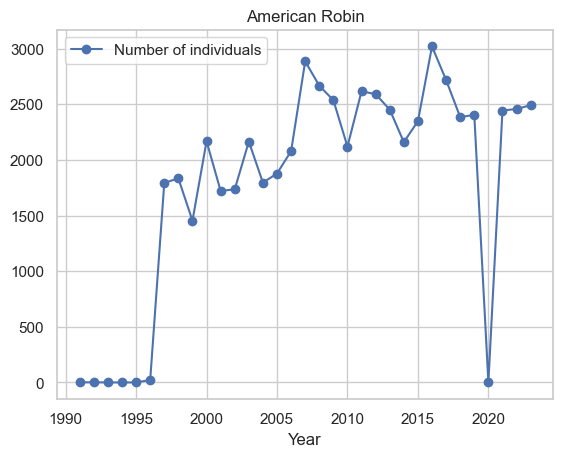

In [91]:
d = Totals[Totals['AOU']==spp][['Year','Number of individuals']].groupby('Year').sum().reset_index()#.plot('Year','Number of individuals')
all_years = pd.DataFrame({'Year': range(d['Year'].min(), d['Year'].max() + 1)})


dd = pd.merge(all_years, d, on='Year', how='left').fillna(0)

plt.figure(figsize=(20, 4))
dd.plot('Year','Number of individuals',linestyle='-', marker='o',
        title=sppname)


Text(8.194444444444445, 0.5, 'Count of years censed')

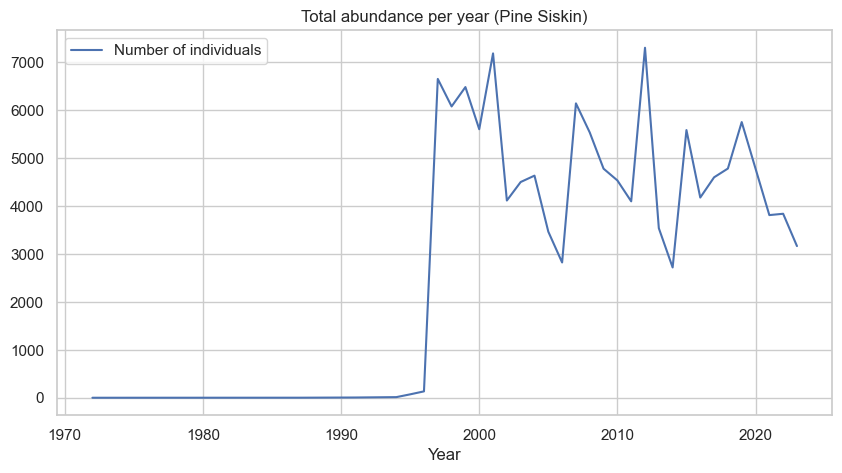

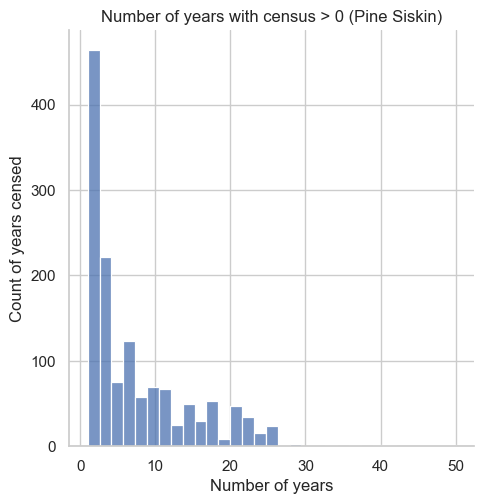

In [129]:
# Total abundance per year for AOU 4920 (Piñon Jay)
Totals[Totals['AOU']==spp][['Year','Number of individuals']].groupby('Year').sum().plot(kind='line', figsize=(10, 5), title='Total abundance per year ('+sppname+')')


# Number of years with census > 0
sns.displot(Totals[Totals['AOU']==spp][['Year','ruta']].groupby('ruta').count()['Year'])
plt.title('Number of years with census > 0 ('+sppname+')')
plt.xlabel('Number of years')
plt.ylabel('Count of years censed')


### Visualizing  maps

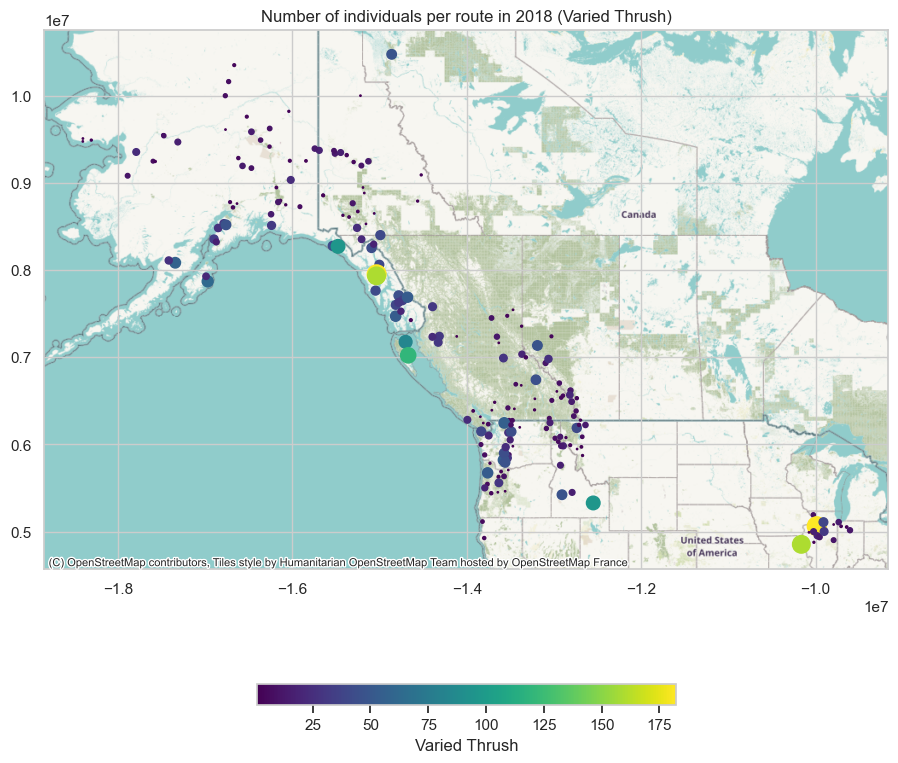

In [20]:
import geopandas as gpd
import contextily as ctx

yr  = 2018 # Plot the number of individuals per route for the specified species in 2022

subTotals = Totals[Totals['AOU']==spp][['Year','ruta','Longitude','Latitude','Number of individuals']]
# Totals.columns
geototals = gpd.GeoDataFrame(
    subTotals, geometry=gpd.points_from_xy(subTotals.Longitude, subTotals.Latitude), crs="EPSG:4326"
)


geototals = geototals.to_crs(epsg=3857)

# ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
ax = geototals[geototals['Year']==yr].plot('Number of individuals', cmap='viridis',  markersize='Number of individuals', 
                                             legend=True,
                                             legend_kwds={'shrink': 0.45,'label':sppname,'orientation': 'horizontal'},  # Adjust the shrink value (e.g., 0.5 for 50%)
                                             figsize=(12, 10),
                                             )
# cbar = plt.colorbar(shrink=0.75)
ax.set_title('Number of individuals per route in '+str(yr)+' ('+sppname+')')
ctx.add_basemap(ax)



## Writing data to a dictionary

The dictionary is organized as follows:

- key: (species, routeID)
- value: [(year, abundance)] 

routeID is composed by joining 'Country Number' `Totals['CountryNum'].astype(str)`, 'State Number' `Totals['StateNum'].astype(str)`, and 'Route Number' `Totals['Route'].astype(str)`

In [131]:
def fill_missing_year_data(
    data_tuples: list[tuple[int, int]],
    start_year: int,
    end_year: int
) -> list[tuple[int, int]]:
    """
    Generates a list of (year, value) tuples for a continuous range of years,
    filling in missing years with a default value of 0.

    Args:
        data_tuples (list[tuple[int, int]]): A list of tuples, where each tuple
                                             is (year, value).
        start_year (int): The first year in the desired continuous range (inclusive).
        end_year (int): The last year in the desired continuous range (inclusive).

    Returns:
        list[tuple[int, int]]: A new list of tuples covering the specified
                               year range, with 0 for years where no data was provided.
                               Returns an empty list if start_year > end_year.
    """
    if not isinstance(data_tuples, list) or not all(isinstance(t, tuple) and len(t) == 2 and isinstance(t[0], int) and isinstance(t[1], int) for t in data_tuples):
        print("Error: 'data_tuples' must be a list of (int, int) tuples.")
        return []
    if not isinstance(start_year, int) or not isinstance(end_year, int):
        print("Error: 'start_year' and 'end_year' must be integers.")
        return []

    if start_year > end_year:
        print(f"Warning: start_year ({start_year}) is greater than end_year ({end_year}). Returning empty list.")
        return []

    # Convert the input list of tuples into a dictionary for faster lookups
    # This maps year -> value
    data_map = {year: value for year, value in data_tuples}

    result_list = []
    # Iterate through the desired year range
    for year in range(start_year, end_year + 1):
        # Check if data exists for the current year
        if year in data_map:
            result_list.append((year, data_map[year]))
        else:
            # If not, append the year with a value of 0
            result_list.append((year, 0))

    return result_list

## TESTING THE FUNCTION ##
# my_data = [(1980, 4), (1968, 20), (1975, 15)]
# first_year = 1966
# last_year = 2024

# print(f"Input data: {my_data}")
# print(f"Desired year range: {first_year}-{last_year}")

# filled_data = fill_missing_year_data(my_data, first_year, last_year)

# filled_data

We will pad the timeseries, starting in 1966 with 0s for those years in which birds were not counted

In [112]:
first_year = 1966
last_year = 2024

totals_dict = {}

# Group the DataFrame by 'Year' and 'RouteDataID'
# Then iterate through each group
for (spp, route_id), group_df in Totals.groupby(['AOU', 'ruta']):
        # Extract the 'Totals' column for the current group and convert it to a list
        totals_list = list(zip(group_df['Year'].tolist(), group_df['Number of individuals'].tolist()))
        # Add the (spp, route_id) tuple as key and the list of totals as value to the dictionary
        totals_dict[(str(spp), str(route_id))] = fill_missing_year_data(totals_list, first_year, last_year)   #totals_list

We may now extract the data by parsing the dictionary. 

Here are a couple functions that will:

- generate a pandas DataFrame for a given species with routeID as columns and years as rows
- for a given routeID, species as columns and years as rows
- for a given year, species as columns and routes rows

you may then export this to a csv if needed

In [ ]:

def species_to_df(species_id: int, data: dict) -> pd.DataFrame:

    """
    Generates a pandas DataFrame for a given species,
    with routes as columns and years as rows.

    Args:
        species_id (int): The name of the species to filter by.
        data (dict): The input dictionary with (species, route) keys
                     and list of (year, abundance) values.

    Returns:
        pd.DataFrame: A DataFrame with years as index and routes as columns.
                      Returns an empty DataFrame if the species is not found.
    """
    df_data = {}
    years = set()

    for (species, route), abundances in data.items():
        if species == species_id:
            if route not in df_data:
                df_data[route] = {}
            for year, abundance in abundances:
                df_data[route][year] = abundance
                years.add(year)

    if not df_data:
        print(f"No data found for species: {species_id}")
        return pd.DataFrame()

    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(df_data, orient='index').transpose()
    df.index.name = 'Year'
    df.columns.name = 'Route'
    return df.sort_index() # Sort by year    


def route_to_df(route_number: int, data: dict) -> pd.DataFrame:
    """
    Generates a pandas DataFrame for a given route number,
    with species as columns and years as rows.

    Args:
        route_number (int): The route number to filter by.
        data (dict): The input dictionary with (species, route) keys
                     and list of (year, abundance) values.

    Returns:
        pd.DataFrame: A DataFrame with years as index and species as columns.
                      Returns an empty DataFrame if the route is not found.
    """
    df_data = {}
    years = set()

    for (species, route), abundances in data.items():
        if route == route_number:
            if species not in df_data:
                df_data[species] = {}
            for year, abundance in abundances:
                df_data[species][year] = abundance
                years.add(year)

    if not df_data:
        print(f"No data found for route: {route_number}")
        return pd.DataFrame()

    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(df_data, orient='index').transpose()
    df.index.name = 'Year'
    df.columns.name = 'Species'
    return df.sort_index() # Sort by year


def year_to_df(year_value: int, data: dict) -> pd.DataFrame:
    """
    Generates a pandas DataFrame for a given year,
    with species as columns and routes as rows.

    Args:
        year_value (int): The year to filter by.
        data (dict): The input dictionary with (species, route) keys
                     and list of (year, abundance) values.

    Returns:
        pd.DataFrame: A DataFrame with routes as index and species as columns.
                      Returns an empty DataFrame if the year is not found.
    """
    df_data = {}
    routes = set()
    species_set = set()

    for (species, route), abundances in data.items():
        for year, abundance in abundances:
            if year == year_value:
                if route not in df_data:
                    df_data[route] = {}
                df_data[route][species] = abundance
                routes.add(route)
                species_set.add(species)

    if not df_data:
        print(f"No data found for year: {year_value}")
        return pd.DataFrame()

    # Create a DataFrame from the collected data
    df = pd.DataFrame.from_dict(df_data, orient='index')
    df.index.name = 'Route'
    df.columns.name = 'Species'
    return df.sort_index(axis=0).sort_index(axis=1) # Sort by route (rows) and species (columns)


**Examples**

- species: '10'  --Western Grebe (_Aechmophorus,occidentalis_)
- routeID: '1241120'
- year: 2018

In [113]:
species_df = species_to_df(spp,totals_dict)

# routes_df = route_to_df('1241120',totals_dict)

# yrs_df = year_to_df(2018,totals_dict)



NameError: name 'species_name' is not defined

In [95]:
species_df

Loading ITables v2.4.2 from the init_notebook_mode cell... (need help?)
